# <div align="center">Genetic Algorithm for Traveling Salesman Problem</div>


# Import libraries:


In [1]:
import numpy as np
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt

# CityGene and TravelPath Classes:


In [2]:
class CityGene:
    """
    Represents a city with its name and coordinates.
    """

    def __init__(self, city_name, coordinates):
        """
        Initialize a CityGene object.

        Parameters:
        - city_name (int): The name or identifier of the city.
        - coordinates (list): The coordinates of the city in the form [x, y].
        """
        self.city_name = city_name
        self.coordinates = coordinates

    def __repr__(self):
        return f"City:{self.city_name}"

    def __eq__(self, other):
        return self.city_name == other.city_name

class TravelPath:
    """
    Represents a path through multiple cities.
    """

    def __init__(self, genes):
        """
        Initialize a TravelPath object.

        Parameters:
        - genes (list): List of CityGene objects representing the path through cities.
        """
        self.fitness_score = 0
        self.total_cost = 0
        self.genes = genes

    def __repr__(self):
        return f'{self.genes} Total Cost: {self.total_cost} Fitness Score:{self.fitness_score}'

# Data Loading:


In [3]:
def load_city_data(file_path):
    """
    Load city data from a CSV file.

    Parameters:
    - file_path (str): Path to the CSV file containing city data.

    Returns:
    - cities (list): List of CityGene objects representing cities.
    """
    city_data = pd.read_csv(file_path)
    cities = []
    for index, row in city_data.iterrows():
        cities.append(CityGene(int(row['City']), [row['x'], row['y']]))
    return cities

# Distance Calculation:

In [4]:
def calculate_distance(start_point, end_point):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    - start_point (list): Coordinates of the starting point.
    - end_point (list): Coordinates of the ending point.

    Returns:
    - distance (float): Euclidean distance between the two points.
    """
    start_point = np.array(start_point, dtype=float)
    end_point = np.array(end_point, dtype=float)
    distance = np.sqrt(np.sum((end_point - start_point)**2))
    return distance

def create_distance_matrix(initial_path):
    """
    Create a distance matrix between cities.

    Parameters:
    - initial_path (list): List of CityGene objects representing cities.

    Returns:
    - distance_matrix (numpy.ndarray): 2D array representing the distance between each pair of cities.
    """
    matrix_size = len(initial_path)
    distance_matrix = np.zeros((matrix_size, matrix_size))
    for i in range(matrix_size):
        for j in range(matrix_size):
            if i != j:
                distance_matrix[i, j] = calculate_distance(initial_path[i].coordinates, initial_path[j].coordinates)
    return distance_matrix

def calculate_path_cost(path, distance_matrix):
    """
    Calculate the total cost of a given path through cities.

    Parameters:
    - path (TravelPath): The path to calculate the cost for.
    - distance_matrix (numpy.ndarray): 2D array representing the distance between each pair of cities.

    Returns:
    - path_cost (float): Total cost of the path.
    """
    path_cost = 0
    for i in range(len(path.genes) - 1):
        city_a = path.genes[i]
        city_b = path.genes[i + 1]
        index_a = int(city_a.city_name) - 1
        index_b = int(city_b.city_name) - 1
        path_cost += distance_matrix[index_a, index_b]
    return path_cost + calculate_distance(path.genes[-1].coordinates, path.genes[0].coordinates)

# Population Generation:

In [5]:
def generate_population(size, distance_matrix):
    """
    Generate an initial population of travel paths.

    Parameters:
    - size (int): Size of the population.
    - distance_matrix (numpy.ndarray): 2D array representing the distance between each pair of cities.

    Returns:
    - population (list): List of TravelPath objects representing the initial population.
    """
    city_list = load_city_data('Data set CSV.csv')
    population = []
    for _ in range(size):
        random_path = TravelPath(list(np.random.permutation(city_list)))
        random_path.total_cost = calculate_path_cost(random_path, distance_matrix)
        random_path.fitness_score = 1 / random_path.total_cost
        population.append(random_path)
    return population

# Fitness Calculation:

In [6]:
def compute_fitness(path, distance_matrix):
    """
    Compute the fitness score of a path.

    Parameters:
    - path (TravelPath): The path to compute the fitness score for.
    - distance_matrix (numpy.ndarray): 2D array representing the distance between each pair of cities.

    Returns:
    - fitness_score (float): Fitness score of the path.
    """
    return 1 / calculate_path_cost(path, distance_matrix)

# Selection, Crossover, and Mutation:

In [7]:
def sort_by_fitness(population):
    """
    Sort a population by fitness score in descending order.

    Parameters:
    - population (list): List of TravelPath objects representing the population.

    Returns:
    - sorted_population (list): Population sorted by fitness score in descending order.
    """
    return sorted(population, key=lambda x: x.fitness_score, reverse=True)

def k_tournament_selection(population, k):
    """
    Perform K-Tournament Selection to select parents for crossover.

    Parameters:
    - population (list): List of TravelPath objects representing the population.
    - k (int): Number of individuals to be selected for each tournament.

    Returns:
    - selected_paths (list): List of selected TravelPath objects.
    """
    selected_paths = []
    for _ in range(len(population)):
        tournament = random.sample(population, k)
        winner = max(tournament, key=lambda x: x.fitness_score)
        selected_paths.append(winner)
    return selected_paths

def partially_matched_crossover(parent_a, parent_b, distance_matrix):
    """
    Perform partially matched crossover between two parent paths.

    Parameters:
    - parent_a (TravelPath): First parent path.
    - parent_b (TravelPath): Second parent path.
    - distance_matrix (numpy.ndarray): 2D array representing the distance between each pair of cities.

    Returns:
    - child_a (TravelPath): Offspring path resulting from crossover with parent A.
    - child_b (TravelPath): Offspring path resulting from crossover with parent B.
    """
    crossover_points = random.sample(range(len(parent_a.genes)), 2)
    child_a = TravelPath(copy.deepcopy(parent_a.genes))
    child_b = TravelPath(copy.deepcopy(parent_b.genes))

    for i in range(min(crossover_points), max(crossover_points)):
        gene_a = parent_b.genes[i]
        gene_b = parent_a.genes[i]

        index_a = child_a.genes.index(gene_a)
        child_a.genes[index_a] = child_a.genes[i]

        index_b = child_b.genes.index(gene_b)
        child_b.genes[index_b] = child_b.genes[i]

        child_a.genes[i] = gene_a
        child_b.genes[i] = gene_b

    child_a.total_cost = calculate_path_cost(child_a, distance_matrix)
    child_b.total_cost = calculate_path_cost(child_b, distance_matrix)

    child_a.fitness_score = 1 / child_a.total_cost
    child_b.fitness_score = 1 / child_b.total_cost

    return child_a, child_b

def perform_crossover(probability, old_population, new_population, distance_matrix, k_tournament):
    """
    Perform crossover operation on the population.

    Parameters:
    - probability (float): Probability of crossover.
    - old_population (list): List of TravelPath objects representing the old population.
    - new_population (list): List of TravelPath objects representing the new population.
    - distance_matrix (numpy.ndarray): 2D array representing the distance between each pair of cities.
    - k_tournament (int): Number of individuals to be selected for each tournament.

    Returns:
    - new_population (list): Updated population after crossover operation.
    """
    num = int(len(old_population) * probability)
    while True:
        parent_paths = k_tournament_selection(old_population, k_tournament)
        parent_a = parent_paths[0]
        parent_b = parent_paths[1]

        child_a, child_b = partially_matched_crossover(parent_a, parent_b, distance_matrix)

        new_population.append(child_a)
        new_population.append(child_b)

        if len(new_population) == len(old_population):
            return new_population

def perform_mutation(probability, new_population, num_elite, distance_matrix):
    """
    Perform mutation operation on the population.

    Parameters:
    - probability (float): Probability of mutation.
    - new_population (list): List of TravelPath objects representing the population.
    - num_elite (int): Number of elite paths to exclude from mutation.
    - distance_matrix (numpy.ndarray): 2D array representing the distance between each pair of cities.

    Returns:
    - new_population (list): Updated population after mutation operation.
    """
    num_mutations = int(len(new_population) * probability)
    for _ in range(num_mutations):
        chromosome_index = random.choice(range(num_elite, len(new_population)))
        mutation_points = random.sample(range(len(new_population[0].genes)), 2)
        max_index = max(mutation_points)
        for i in range(min(mutation_points), max_index):
            new_population[chromosome_index].genes[max_index], new_population[chromosome_index].genes[i] = new_population[chromosome_index].genes[i], new_population[chromosome_index].genes[max_index]
            max_index -= 1

        new_population[chromosome_index].total_cost = calculate_path_cost(new_population[chromosome_index], distance_matrix)
        new_population[chromosome_index].fitness_score = 1 / new_population[chromosome_index].total_cost

    return new_population

# Genetic Algorithm Main Loop:

In [8]:
def genetic_algorithm(old_population, num_elite, mutation_probability, crossover_probability, distance_matrix, k_tournament):
    """
    Perform the genetic algorithm on the population.

    Parameters:
    - old_population (list): List of TravelPath objects representing the old population.
    - num_elite (int): Number of elite paths to preserve.
    - mutation_probability (float): Probability of mutation.
    - crossover_probability (float): Probability of crossover.
    - distance_matrix (numpy.ndarray): 2D array representing the distance between each pair of cities.
    - k_tournament (int): Number of individuals to be selected for each tournament.

    Returns:
    - new_population (list): List of TravelPath objects representing the new population.
    """
    new_population = []

    elites = sort_by_fitness(old_population)
    new_population.extend(elites[:num_elite])

    new_population = perform_crossover(crossover_probability, old_population, new_population, distance_matrix, k_tournament)
    new_population = perform_mutation(mutation_probability, new_population, num_elite, distance_matrix)

    return new_population

# Plotting Function:

In [9]:
def plot_solution(solution):
    """
    Plot the solution path on a 2D graph.

    Parameters:
    - solution (TravelPath): The best solution path to be plotted.
    """
    x_coords = []
    y_coords = []
    city_names = []
    for gene in solution.genes:
        x_coords.append(float(gene.coordinates[0]))
        y_coords.append(float(gene.coordinates[1]))
        city_names.append('City' + str(gene.city_name))
    fig, ax = plt.subplots()
    def animate(i):
        ax.clear()
        ax.plot(x_coords[:i+1], y_coords[:i+1], marker='o')
    plt.plot(x_coords, y_coords, marker='o')
    for i in range(len(x_coords)):
        plt.text(x_coords[i]+0.1, y_coords[i]+0.1, city_names[i], fontsize=10)
    plt.title(f'Genetic Algorithm Total Cost: {solution.total_cost}')
    plt.show()

# Main Function:

284.3810904080332
[City:13, City:1, City:11, City:4, City:6, City:8, City:10, City:14, City:12, City:3, City:7, City:5, City:9, City:15, City:2, City:13] Total Cost: 284.3810904080332 Fitness Score:0.003516408206203826


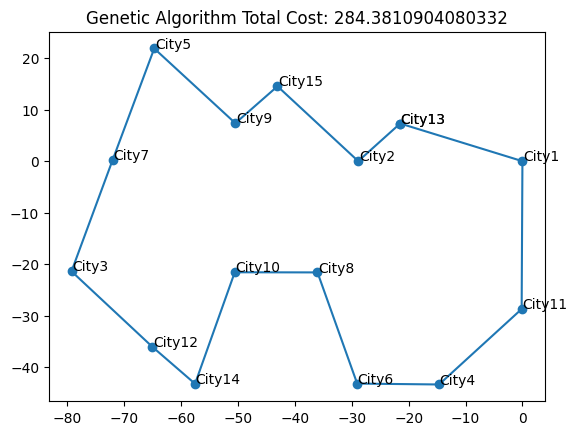

In [10]:
if __name__ == "__main__":
    mutation_probability = 0.6
    crossover_probability = 0.8
    population_size = 400
    elite_count = 4
    generation_count = 100
    k_tournament = 5  # Set the K value for K-Tournament Selection
    city_data = load_city_data('Data set CSV.csv')
    distance_matrix = create_distance_matrix(city_data)
    population = generate_population(population_size, distance_matrix)
    for _ in range(generation_count):
        population = genetic_algorithm(population, elite_count, mutation_probability, crossover_probability, distance_matrix, k_tournament)
        population = sort_by_fitness(population)
    best_solution = sort_by_fitness(population)[0]
    print(calculate_path_cost(best_solution, distance_matrix))
    best_solution.genes.append(best_solution.genes[0])
    print(best_solution)
    plot_solution(best_solution)